# Implementation of a Language Model (RNN and Transformer-based)
#### Autorka: Julia Rybska
source code: https://github.com/juliaryb/computational-linguistics

In [1]:
import os, math, time, json, csv, random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import config  # uses your uploaded config.py
from prep_data import download_high_quality
from tokenizer import ensure_char_tokenizer, ensure_spm_tokenizer
from model import LSTMModel, TransformerDecoderOnly
from data import LanguageModelDataset
from generate import generate_text

### Data
- pobrane ze speakleash i odfiltrowane wg high quality
- train: 1000 novels corpus CLARIN
- val: wolne lektury corpus

In [2]:
# Download high-quality Polish datasets (once)
# download_high_quality("1000_novels_corpus_CLARIN-PL", config.TRAIN_PATH)
# download_high_quality("wolne_lektury_corpus", config.VALID_PATH)

### Config

In [3]:
print("DEVICE:", config.DEVICE)
print("MODEL_ARCH:", config.MODEL_ARCH)
print("TOKENIZER_TYPE:", config.TOKENIZER_TYPE)
print("SEQ_LEN:", config.SEQ_LEN, "BATCH_SIZE:", config.BATCH_SIZE, "EPOCHS:", config.EPOCHS)

DEVICE: cpu
MODEL_ARCH: lstm
TOKENIZER_TYPE: spm
SEQ_LEN: 64 BATCH_SIZE: 16 EPOCHS: 8


### Training
- Training can be run using `python train.py` after setting desired config parameters in `config.py`.
- The same tokeniser (sentence-piece) was used for both architectures (with vocabulary size 8000). 
- One section is devoted to the LSTM architecture and results. 
- Another to the transformer

### LSTM

In [11]:
# train the LSTM model (and tokeniser - it'll then be reused for the transformer)
!python train.py

Using device: cpu
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/home/julia/Documents/lingwistyka/computational-linguistics/data/lektury_train.txt --model_prefix=/home/julia/Documents/lingwistyka/computational-linguistics/tokenizers/sentence-piece --model_type=unigram --vocab_size=8000 --character_coverage=1.0 --normalization_rule_name=nfkc --add_dummy_prefix=true --byte_fallback=false --unk_id=0 --bos_id=1 --eos_id=2 --pad_id=3 --input_sentence_size=2000000 --shuffle_input_sentence=true
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/julia/Documents/lingwistyka/computational-linguistics/data/lektury_train.txt
  input_format: 
  model_prefix: /home/julia/Documents/lingwistyka/computational-linguistics/tokenizers/sentence-piece
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 2000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_f

In [5]:
# check tokenizer
train_path = os.path.join(config.DATA_DIR, config.TRAIN_FILE)
tok_path   = os.path.join(config.DATA_DIR, config.TOKENIZER_FILE)

tok = ensure_spm_tokenizer(train_path, tok_path)

print("Vocab size:", tok.get_vocab_size(), "pad/bos/eos/unk:",
      tok.pad_id, tok.bos_id, tok.eos_id, tok.unk_id)

# quick sanity
s = "Może fajnie byłoby"
ids = tok.encode(s)
print(ids[:20], "... ->", tok.decode(ids))

Vocab size: 8000 pad/bos/eos/unk: 3 1 2 0
[1, 657, 634, 29, 46, 2257, 2] ... -> Może fajnie byłoby


In [7]:
EMBED_DIM  = 128     # try 128/256 for a stronger baseline
HIDDEN_DIM = 128    # try 256/512 for a stronger baseline
NUM_LAYERS = 2
DROPOUT    = 0.1

print("embedding layer size:", config.EMBED_DIM)
print("hidden layer size:", config.HIDDEN_DIM)
print("num of layers:", config.NUM_LAYERS)
print("dropout:", config.DROPOUT)

embedding layer size: 128
hidden layer size: 128
num of layers: 2
dropout: 0.1


In [8]:
vocab_size = tok.get_vocab_size()
model = LSTMModel(vocab_size, config.EMBED_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                      dropout=config.DROPOUT, tokenizer=tok).to(config.DEVICE)

print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Params: 2320192


#### Metrics and results

In [10]:
df = pd.read_csv(config.LOG_CSV)
df

,epoch,train_loss,train_ppl,val_loss,val_ppl,epoch_time_sec
0,1,7.134354,1254.326489,6.918037,1010.334680,7.554808
1,2,6.691460,805.497527,6.673030,790.787815,7.745584
2,3,6.465634,642.671968,6.569805,713.230508,7.638299
3,4,6.298223,543.605065,6.450093,632.761293,7.514045
4,5,6.153760,470.482866,6.373709,586.227970,7.875322
5,6,6.045913,422.383200,6.302482,545.925121,8.031184
6,7,5.961341,388.130274,6.257265,521.789683,8.351541
7,8,5.889058,361.064848,6.225413,505.431981,7.883004


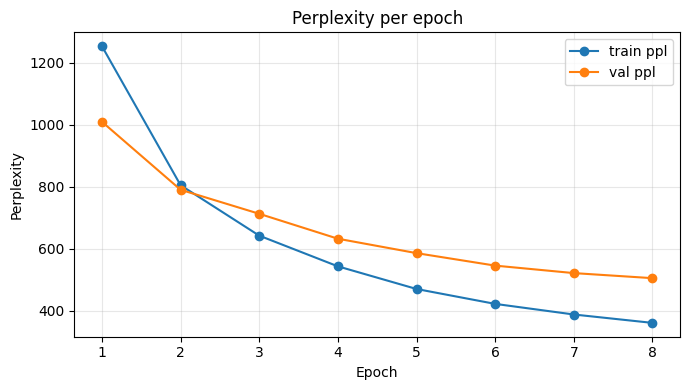

In [11]:
plt.figure(figsize=(7,4))
plt.plot(df["epoch"], df["train_ppl"], marker="o", label="train ppl")
plt.plot(df["epoch"], df["val_ppl"], marker="o", label="val ppl")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity per epoch")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

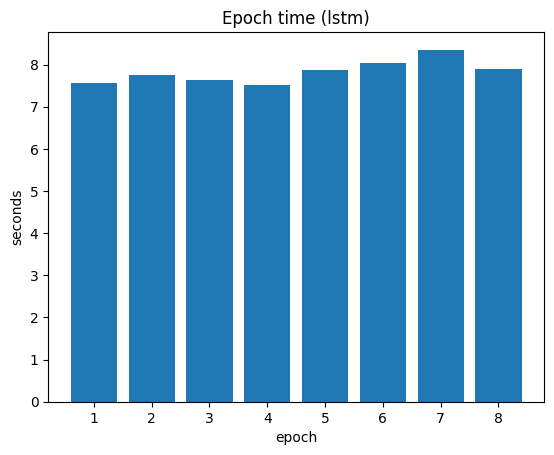

In [13]:
plt.figure()
plt.bar(df["epoch"], df["epoch_time_sec"])
plt.xlabel("epoch"); plt.ylabel("seconds"); plt.title(f"Epoch time ({config.MODEL_ARCH})")
plt.show()

#### prompts and model's creativity

In [14]:
PROMPTS = [
    "Może fajnie byłoby",
    "Na początku było",
    "Kiedy słońce zaszło",
    "W pewnym momencie",
    "To nie jest zwykła opowieść",
    "Niech Cię nie zdziwi",
    "W Krakowie, na rynku",
    "Zaraz będzie ciemno",
    "Czasem wystarczy",
    "Gdybyś tylko wiedział"
]

In [20]:
# load best weights for the selected arch
sd = torch.load(config.MODEL_SAVE_PATH, map_location=config.DEVICE, weights_only=True)
model.load_state_dict(sd)
model.eval()

gen_rows = []
for i, p in enumerate(PROMPTS, 1):
    t0 = time.perf_counter()
    out = generate_text(model, tok, prompt=p, max_len=120, temperature=0.9)
    dt = time.perf_counter() - t0
    gen_rows.append({"idx": i, "prompt": p, "gen_time_s": dt, "len_chars": len(out), "output": out})
    print("\n", out)

gen_df = pd.DataFrame(gen_rows)
display(gen_df[["idx","prompt","gen_time_s","len_chars"]])

True

 Może fajnie byłobyyiąc, które nie ciało. ⁇ Wdyrzuceniaę, ⁇ Podkrętsz się poży, ⁇ A Prawowej jest je? ⁇ Mywsza i te wsku... ⁇ Ta Łowie urerzych gościa, a takć ciekaw. ⁇ A gożł dzienniku, aby z jej dwa zpieżi w wyłgoz innych, ⁇ Ty niezewsznej ty widnokręga — ⁇ Weśś się zwęły, ⁇ Kdybram aniżeli kuścit głową, ⁇ Sbajach przez
True

 Na początku byłoiów przyłą dnia, ⁇ — to byatyć ma światło, ⁇ e niestetyło z koklem i godzin. Zaczęłdziy, że w jabierlu!” do swej zawiele. ⁇ Cędni na nią cenyych, odda jej wielu. ⁇ Asmkapno wy wodą, a każdy czas tam razem po ogólnezamnie, ⁇ I to przeców twojej w nich środek: ⁇ Pody Vytażli nikczemna,ukdni, ⁇ D boca! ⁇ Oboga zastąpiłam sięujący!
True

 Kiedy słońce zaszło z ciemneki, Umiem bardzo. — Zdawało wiatry Agali, czy cię wieści nic piskonie osgi i milczał. ⁇ Delli w pomiędzy schodów, ale ia fra cili niepodtekeń, to śmiałem, zsięgu — najczydy Bogu w otchłani nagle we kobiet jej krótkoem raz, wiele zechcena duszy ⁇ Aby, nie zarazem widząc ku kryrzy, ⁇

,idx,prompt,gen_time_s,len_chars
0,1,Może fajnie byłoby,0.060127,322
1,2,Na początku było,0.038274,345
2,3,Kiedy słońce zaszło,0.038979,413
3,4,W pewnym momencie,0.036596,384
4,5,To nie jest zwykła opowieść,0.061143,417
5,6,Niech Cię nie zdziwi,0.054255,387
6,7,"W Krakowie, na rynku",0.035853,377
7,8,Zaraz będzie ciemno,0.037060,367
8,9,Czasem wystarczy,0.035134,395
9,10,Gdybyś tylko wiedział,0.037241,403


### Transformer